# 재귀 한계에 도달하기 전 상태 반환 방법

<div class="admonition tip">
    <p class="admonition-title">전제 조건</p>
    <p>
        이 가이드는 다음에 대한 이해를 전제로 합니다:
        <ul>
            <li>
                <a href="https://langchain-ai.github.io/langgraphjs/concepts/low_level/#graphs">
                    그래프
                </a>
            </li>
            <li>
                <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#recursion-limit">
                    재귀 한계
                </a>
            </li>
            <li>
                <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes">
                    노드
                </a>
            </li>
        </ul>
    </p>
</div> 

[그래프 재귀 한계 설정](https://langchain-ai.github.io/langgraph/how-tos/recursion-limit/)은 그래프의 실행 시간을 제어하는 데 도움이 될 수 있지만, 재귀 한계에 도달하면 그래프가 오류를 반환하게 되며 - 이는 모든 사용 사례에 이상적이지 않을 수 있습니다. 대신 재귀 한계에 도달하기 *직전*의 상태 값을 반환하는 것을 원할 수 있습니다. 이 가이드는 이를 수행하는 방법을 보여줍니다.


## 설정

먼저, 필요한 패키지를 설치합시다:


In [1]:
%%capture --no-stderr
%pip install -U langgraph


<div class="admonition tip">
    <p class="admonition-title">LangGraph 개발을 위한 <a href="https://smith.langchain.com">LangSmith</a> 설정하기</p>
    <p style="padding-top: 5px;">
        LangSmith에 가입하여 LangGraph 프로젝트의 문제를 빠르게 발견하고 성능을 개선하세요. LangSmith는 LangGraph로 구축된 LLM 앱을 디버깅하고, 테스트하며, 모니터링하는 데 사용되는 추적 데이터를 제공합니다 — 시작하는 방법에 대한 자세한 내용은 <a href="https://docs.smith.langchain.com">여기</a>를 읽어보세요. 
    </p>
</div>


## 상태를 반환하지 않고

이번 예제에서는 항상 재귀 한계에 도달하는 더미 그래프를 정의할 것입니다. 먼저, 상태를 반환하지 않는 방식으로 구현하고 재귀 한계에 도달하는 것을 보여주겠습니다. 이 그래프는 ReAct 아키텍처를 기반으로 하지만 실제로 결정을 내리거나 행동을 취하는 대신 무한 루프를 돌기만 합니다.


In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph import START, END


class State(TypedDict):
    value: str
    action_result: str


def router(state: State):
    if state["value"] == "end":
        return END
    else:
        return "action"


def decision_node(state):
    return {"value": "keep going!"}


def action_node(state: State):
    # Do your action here ...
    return {"action_result": "what a great result!"}


workflow = StateGraph(State)
workflow.add_node("decision", decision_node)
workflow.add_node("action", action_node)
workflow.add_edge(START, "decision")
workflow.add_conditional_edges("decision", router, ["action", END])
workflow.add_edge("action", "decision")
app = workflow.compile()


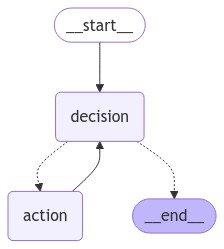

In [3]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))


그래프가 항상 재귀 한계에 도달한다는 것을 확인해 보겠습니다:


In [4]:
from langgraph.errors import GraphRecursionError

try:
    app.invoke({"value": "hi!"})
except GraphRecursionError:
    print("Recursion Error")


Recursion Error


## 반환 상태와 함께

재귀 한도에 도달하는 것을 피하기 위해, 우리는 `remaining_steps`라는 새로운 키를 상태에 추가할 수 있습니다. 이것은 재귀 한도에 도달할 때까지 남은 단계 수를 추적합니다. 그런 다음 `remaining_steps`의 값을 확인하여 그래프 실행을 종료하고 `RecursionError`를 유발하지 않고 사용자에게 상태를 반환해야 하는지 결정할 수 있습니다.

이를 위해 우리는 특별한 `RemainingSteps` 주석을 사용할 것입니다. 내부적으로 이는 특별한 `ManagedValue` 채널을 생성합니다. 이는 그래프 실행 기간 동안만 존재하는 상태 채널입니다.

우리의 `action` 노드는 항상 그래프에 최소 2단계의 추가 단계를 유도하기 때문에(왜냐하면 `action` 노드는 항상 그 이후에 `decision` 노드를 호출하기 때문입니다), 우리는 이 채널을 사용하여 우리가 한도 2단계 이내에 있는지 확인할 것입니다.

이제 그래프를 실행할 때 오류가 발생하지 않고 재귀 한도에 도달하기 전에 상태의 마지막 값을 얻어야 합니다.


In [5]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from typing import Annotated

from langgraph.managed.is_last_step import RemainingSteps


class State(TypedDict):
    value: str
    action_result: str
    remaining_steps: RemainingSteps


def router(state: State):
    # Force the agent to end
    if state["remaining_steps"] <= 2:
        return END
    if state["value"] == "end":
        return END
    else:
        return "action"


def decision_node(state):
    return {"value": "keep going!"}


def action_node(state: State):
    # Do your action here ...
    return {"action_result": "what a great result!"}


workflow = StateGraph(State)
workflow.add_node("decision", decision_node)
workflow.add_node("action", action_node)
workflow.add_edge(START, "decision")
workflow.add_conditional_edges("decision", router, ["action", END])
workflow.add_edge("action", "decision")
app = workflow.compile()


In [6]:
app.invoke({"value": "hi!"})


{'value': 'keep going!', 'action_result': 'what a great result!'}

완벽해요! 우리 코드가 예상한 대로 오류 없이 실행되었어요!
